In [1]:
import pandas as pd
import datetime
import matplotlib
from matplotlib import pyplot as plt
import seaborn
import numpy as np
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16, 5)

1.读取原始数据

In [2]:
user_df=pd.read_csv('../data/tianchi_mobile_recommend_train_user.csv')
item_df=pd.read_csv('../data/tianchi_mobile_recommend_train_item.csv')

In [3]:
user_df.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time
0,98047837,232431562,1,NaN,4245,2014-12-06 02
1,97726136,383583590,1,NaN,5894,2014-12-09 20
2,98662432,320593836,1,96nn52n,6562,2014-12-06 10
3,98145908,290208520,1,NaN,13926,2014-12-16 21
4,93784494,337869048,1,NaN,3979,2014-12-03 20


In [4]:
item_df.head()

,item_id,item_geohash,item_category
0,312051294,NaN,8270
1,99999754,NaN,7393
2,131746128,NaN,7876
3,385731330,NaN,10544
4,100004415,NaN,3064


2.查看数据总量

In [5]:
print('用户数量：',user_df.user_id.unique().shape[0])
print('商品总数量：',user_df.item_id.unique().shape[0])
print('操作记录总数：',len(user_df))
print('要预测的商品总数量:',item_df.item_id.unique().shape[0])

用户数量： 9988
商品总数量： 2803933
操作记录总数： 11881309
要预测的商品总数量: 310582


In [6]:
# 只预测这个set中出现的商品
item_id_set=set(item_df.item_id)
print('要预测的商品总数量:',len(item_id_set))

要预测的商品总数量: 310582


3.数据格式转换(时间转换)

In [7]:
%%time
user_df['day']=user_df.time.apply(lambda x:datetime.datetime.strptime(x[:-3], "%Y-%m-%d"))
user_df['hour']=user_df.time.apply(lambda x:int(x[-2:]))

CPU times: user 1min 52s, sys: 168 ms, total: 1min 52s
Wall time: 1min 52s


4.做一些数据统计

In [8]:
print('每种行为的数量')
pd.DataFrame(user_df.behavior_type.value_counts())

每种行为的数量


,behavior_type
1,11195835
3,333739
2,235116
4,116619


每天的行为数量


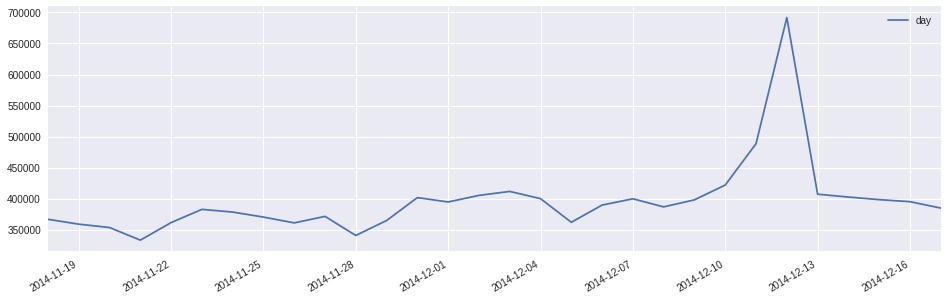

In [9]:
print('每天的行为数量')
pd.DataFrame(user_df.day.value_counts()).plot()

5.将12月17日加入购物车的商品作为预测结果

In [10]:
def submit(result_df,filename='../data/submission.csv'):
    result_df=result_df.loc[:,['user_id','item_id']].drop_duplicates()
    print('结果共有：',len(result_df),'条数据')
    result_df.to_csv(filename,index=False)
    
result_df=user_df[(user_df.day=='2014-12-17')&(user_df.behavior_type==3)]
# 筛选出要预测的商品，因为我们只评估这部分商品
result_df=result_df[result_df.item_id.apply(lambda id:id in item_id_set)]
submit(result_df,'../data/submission1.csv')

结果共有： 1215 条数据


6.将12月17日最后400条加入购物车的商品记录作为预测结果

为什么选择400条，因为统计出来历史记录中，每天平均有400条购买记录

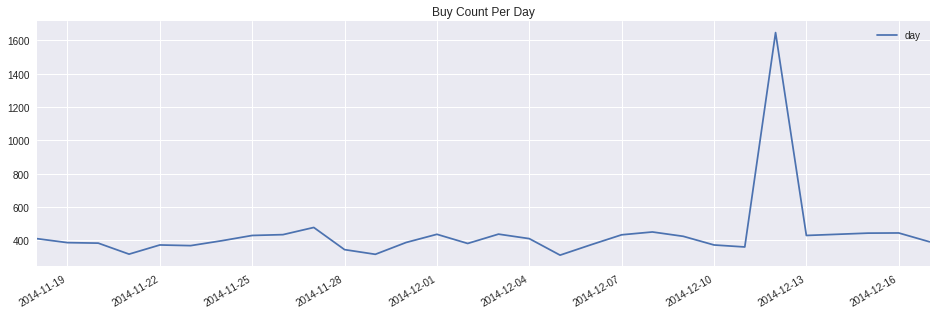

In [12]:
o2o_user_df=user_df[user_df.item_id.apply(lambda id:id in item_id_set)]
buy_cnt=o2o_user_df[o2o_user_df.behavior_type==4].drop_duplicates(subset=['user_id','item_id','day']).day.value_counts()
pd.DataFrame(buy_cnt).plot()
plt.title('Buy Count Per Day')

In [13]:
result_df=result_df.sort_values('hour',ascending=False).loc[:,['user_id','item_id']].drop_duplicates()
result_df=result_df.iloc[:400]
submit(result_df,'../data/submission2.csv')

结果共有： 400 条数据


# 机器学习方法

In [15]:
user_df=user_df[user_df.day>='2014-12-14']
o2o_user_df=o2o_user_df[o2o_user_df.day>='2014-12-14']
print('数据个数：',len(user_df))
print('与要预测商品相关的数据个数',len(o2o_user_df))

数据个数： 1580773
与要预测商品相关的数据个数 186911


In [16]:
def get_answer_dict(date):
    answer = user_df[(user_df.day==date)&(user_df.behavior_type==4)]
    answer = set(answer.apply(lambda item:'%s-%s'%(item.user_id,item.item_id),axis=1))
    return answer

def label_it(train_xs_df,target_date):
    answer=get_answer_dict(target_date)
    train_xs_df['label']=train_xs_df.apply(lambda item:1 if '%d-%d'%(item.user_id,item.item_id) in answer else 0,axis=1)
    return train_xs_df

## 抽取特征

In [18]:
%%time

def get_features(target_date,user_df):
    xs=[]
    cnt=0
    #target_date=datetime.datetime(2014,12,17)
    start_date=target_date-datetime.timedelta(2)
    tmp_df=user_df[(user_df.day>=start_date)&(user_df.day<target_date)]

    for gid,items in tmp_df.groupby(by=['user_id','item_id']):
        user_id,item_id=gid
        x=[user_id,item_id]
        vals=np.zeros([2,3,4])
        for item in items.itertuples():
            day=(target_date-item.day).days-1
            hour=int(item.hour/8)
            behavior=item.behavior_type-1
            vals[day][hour][behavior]+=1
        x.extend(list(vals.reshape((24))))
        xs.append(x)
        cnt+=1
        if cnt%10000==0:
            print(datetime.datetime.now(),'processed %d'%(cnt,))

    headers=['user_id','item_id']
    for i in range(2):
        for j in range(3):
            for k in range(4):
                headers.append('d%d_h%d_b%d'%(i+1,j+1,k+1))
    xs_df=pd.DataFrame(xs,columns=headers)
    return xs_df

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.54 µs


商品在我们这里可分为o2o商品，和非o2o商品。我们只预测o2o商品的，但这部分数据正例个数太小，会使模型学习得不够充分，
所以我们在训练的时候，要所有的商品的数据（o2o商品和非o2o商品都用）。

但对于验证集和测试集来说，我们只预测o2o商品就可以了

In [20]:
%%time
train_xs_df=get_features(datetime.datetime(2014,12,16),user_df)
print(datetime.datetime.now(),'train_xs_df processed')
# 验证集和测试集只使用o2o的商品就可以了
valid_xs_df=get_features(datetime.datetime(2014,12,17),o2o_user_df)
print(datetime.datetime.now(),'valid_xs_df processed')
test_xs_df=get_features(datetime.datetime(2014,12,18),o2o_user_df)
print(datetime.datetime.now(),'test_xs_df processed')

2017-10-27 10:52:08.534676 processed 10000
2017-10-27 10:52:21.606380 processed 20000
2017-10-27 10:52:34.541751 processed 30000
2017-10-27 10:52:47.398063 processed 40000
2017-10-27 10:53:00.253575 processed 50000
2017-10-27 10:53:13.049908 processed 60000
2017-10-27 10:53:26.178855 processed 70000
2017-10-27 10:53:39.225559 processed 80000
2017-10-27 10:53:52.371353 processed 90000
2017-10-27 10:54:05.338162 processed 100000
2017-10-27 10:54:18.347312 processed 110000
2017-10-27 10:54:31.347052 processed 120000
2017-10-27 10:54:44.134278 processed 130000
2017-10-27 10:54:57.365394 processed 140000
2017-10-27 10:55:10.160365 processed 150000
2017-10-27 10:55:23.229054 processed 160000
2017-10-27 10:55:36.302503 processed 170000
2017-10-27 10:55:49.461424 processed 180000
2017-10-27 10:56:02.670976 processed 190000
2017-10-27 10:56:15.781342 processed 200000
2017-10-27 10:56:28.757759 processed 210000
2017-10-27 10:56:41.808151 processed 220000
2017-10-27 10:56:54.789938 processed 2300

In [21]:
label_it(train_xs_df,datetime.datetime(2014,12,16))
label_it(valid_xs_df,datetime.datetime(2014,12,17))

,user_id,item_id,d1_h1_b1,d1_h1_b2,d1_h1_b3,d1_h1_b4,d1_h2_b1,d1_h2_b2,d1_h2_b3,d1_h2_b4,...,d2_h1_b4,d2_h2_b1,d2_h2_b2,d2_h2_b3,d2_h2_b4,d2_h3_b1,d2_h3_b2,d2_h3_b3,d2_h3_b4,label
0,4913,13017276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0
1,4913,28137461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0
2,4913,49377927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0
3,4913,53738139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4913,66149052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0
5,4913,68000960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,4913,70376267,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,4913,76478799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,4913,78219126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0
9,4913,84593536,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [23]:
positive_num=np.sum(train_xs_df.label)
negative_num=len(train_xs_df)-positive_num
print('正样本个数',positive_num,'负样本个数',negative_num,'负正样本比例',negative_num/positive_num)

正样本个数 651 负样本个数 339439 负正样本比例 521.4116743471582


## 对正样本进行过采样

In [24]:

positive_xs_df=train_xs_df[train_xs_df.label==1]

positive_xs_df=positive_xs_df.sample(n=40000,replace=True)

sample_xs_df=pd.concat([train_xs_df,positive_xs_df])

sample_xs_df=sample_xs_df.sample(frac=1.0)

In [25]:
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer
from sklearn.metrics import precision_recall_fscore_support,precision_score,recall_score,f1_score

## 对特征进行归一化处理

In [26]:
scaler=Normalizer(norm='l1')
scaler.fit(sample_xs_df.drop(['user_id','item_id','label']))

Normalizer(copy=True, norm='l1')

In [27]:
train_xs=scaler.transform(sample_xs_df.drop(['user_id','item_id','label'],axis=1))
valid_xs=scaler.transform(valid_xs_df.drop(['user_id','item_id','label'],axis=1))
test_xs=scaler.transform(test_xs_df.drop(['user_id','item_id'],axis=1))

In [39]:
answer_cnt=len(o2o_user_df[(o2o_user_df.day=='2014-12-17')&(o2o_user_df.behavior_type==4)])
def evaluate(ytrue,ypred,answer_cnt):
    ypred=ypred>0.5
    right_cnt=np.sum(ytrue&ypred)
    predict_cnt=np.sum(ypred)
    precision=right_cnt/predict_cnt
    recall=right_cnt/answer_cnt
    f1=0
    if precision>0 or recall>0:
        f1=2*precision*recall/(precision+recall)
    print('预测数量',predict_cnt,'答案数量',answer_cnt)
    print('正确个数',right_cnt)
    print('precision',precision)
    print('recall',recall)
    print('f1',f1)
    return precision,recall,f1

## 逻辑回归模型

In [40]:
clf=LogisticRegression(C=10)
#训练模型
clf.fit(train_xs,sample_xs_df.label)
#输出验证集结果
valid_yp=clf.predict(valid_xs)
#输出测试集结果
test_yp=clf.predict(test_xs)
#结果线下评估
evaluate(valid_xs_df.label,valid_yp,answer_cnt)
#测试集结果提交到文件中
test_xs_df['yp']=test_yp
submit(test_xs_df[test_xs_df.yp==1],filename='../data/submission_lr.csv')

预测数量 497 答案数量 432
正确个数 20
precision 0.0402414486922
recall 0.0462962962963
f1 0.043057050592
结果共有： 593 条数据


## 梯度提升决策树

In [45]:
clf=GradientBoostingClassifier(n_estimators=200)
clf.fit(train_xs,sample_xs_df.label)
# 这里可以用predict也可以用predict_proba
# predict只输出0和1，
# predict_proba 可以输出概率值
valid_yp=clf.predict_proba(valid_xs)[:,1]
test_yp=clf.predict_proba(test_xs)[:,1]
evaluate(valid_xs_df.label,valid_yp,answer_cnt)
test_xs_df['yp']=test_yp
submit(test_xs_df[test_xs_df.yp>0.5],filename='../data/submission_gbdt.csv')

预测数量 914 答案数量 432
正确个数 43
precision 0.04704595186
recall 0.099537037037
f1 0.0638930163447
结果共有： 983 条数据


## 随机森林模型

In [46]:
clf=RandomForestClassifier(n_estimators=200)
clf.fit(train_xs,sample_xs_df.label)
# 这里可以用predict也可以用predict_proba
# predict只输出0和1，
# predict_proba 可以输出概率值
valid_yp=clf.predict_proba(valid_xs)[:,1]
test_yp=clf.predict_proba(test_xs)[:,1]
evaluate(valid_xs_df.label,valid_yp,answer_cnt)
test_xs_df['yp']=test_yp
submit(test_xs_df[test_xs_df.yp>0.5],filename='../data/submission_rf.csv')

预测数量 890 答案数量 432
正确个数 26
precision 0.0292134831461
recall 0.0601851851852
f1 0.0393343419062
结果共有： 932 条数据
